In [3]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import random
import time

In [4]:
# Mount drive
# from google.colab import drive
# drive.mount('/content/drive')
RSEED=42

In [5]:
# Current path
#path = '/content/drive/MyDrive/Colab Notebooks/Work/Reactors/Pseudomonas Reactor/'
path = ''

## Import Bioreactors data

In [6]:
RSEED = 42
np.random.seed(RSEED)
random.seed(RSEED)

In [7]:
# Load bioreactor data
full_sheet = pd.ExcelFile(path + 'BioreactorPsdmData.xlsx')
df_adip7d  = pd.read_excel(full_sheet, 'bioreactors 7d')
df_lostbio7d  = pd.read_excel(full_sheet, 'lost biomass 7d')

# Group the dataframe by 'reactor'
reactor_dfs = {name: group.reset_index(drop=True) for name, group in df_adip7d.groupby('reactor')}

# Get list of reactor keys and shuffle
reactor_keys = list(reactor_dfs.keys())
random.shuffle(reactor_keys)

for key in reactor_keys:
    reactor_dfs[key] = reactor_dfs[key].sample(frac=1).reset_index(drop=True)

In [8]:
df_adip7d.head(5)

,reactor,media,glucose,flow_rate_microL,flow_rate,cychl,time,adipic_acid,out_biomass,out_biomas_dg
0,Reactor_1,0.25,2,195,0.195,10,1,0.000000,28.872288,0.288723
1,Reactor_1,0.25,2,195,0.195,10,2,0.093127,35.369568,0.353696
2,Reactor_1,0.25,2,195,0.195,10,3,0.205484,24.178003,0.241780
3,Reactor_1,0.25,2,195,0.195,10,4,0.189075,28.612397,0.286124
4,Reactor_1,0.25,2,195,0.195,10,5,0.169618,28.295654,0.282957


## Basic training

In [9]:
# Crop strings
input_columns = ['media', 'glucose', 'flow_rate', 'cychl', 'time']
output_columns = ['adipic_acid', 'out_biomas_dg']


X = df_adip7d[input_columns].values     # Input values
y = df_adip7d[output_columns].values    # Output values
reactor_labels = df_adip7d["reactor"].values
unique_reactor_labels = np.unique(reactor_labels) # Get unique reactor names

In [16]:
kf = KFold(n_splits=8, shuffle=True, random_state=RSEED)
fold_scores = []

for train_reactor_idx, val_reactor_idx in kf.split(unique_reactor_labels):
    
    # Randomly choose the reactors for training and validating
    train_reactors = unique_reactor_labels[train_reactor_idx]
    val_reactors   = unique_reactor_labels[val_reactor_idx]

    # Masks for spliting the reactors
    train_mask = np.isin(reactor_labels, train_reactors)
    val_mask   = np.isin(reactor_labels, val_reactors)
    
    # Split reactors into train/validation
    X_train, X_val = X[train_mask], X[val_mask]
    y_train, y_val = y[train_mask], y[val_mask]

    # Define the RF model
    model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=RSEED)

    # Train the model
    model.fit(X_train, y_train)

    # Validate
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    fold_scores.append(mse)

print(f"Mean MSE: {np.mean(fold_scores)}")
print(f"MSE StanDev: {np.std(fold_scores)}")

Mean MSE: 0.09253717961572515
MSE StanDev: 0.07891749453427854


## Hyperparameter tunning

In [17]:
n_trees = [50, 100, 150, 200, 250, 300, 350, 400, 450]
depths =  [None, 3, 5,   7,   9,   11,  13,  15, 17, 19]

A_heatmap_avg = np.zeros((len(n_trees), len(depths)))
A_heatmap_std = np.zeros((len(n_trees), len(depths)))

for i in range(len(n_trees)):
    for j in range(len(depths)):
        kf = KFold(n_splits=8, shuffle=True, random_state=RSEED)
        fold_scores = []

        for train_reactor_idx, val_reactor_idx in kf.split(unique_reactor_labels):
            
            # Randomly choose the reactors for training and validating
            train_reactors = unique_reactor_labels[train_reactor_idx]
            val_reactors   = unique_reactor_labels[val_reactor_idx]

            # Masks for spliting the reactors
            train_mask = np.isin(reactor_labels, train_reactors)
            val_mask   = np.isin(reactor_labels, val_reactors)
            
            # Split reactors into train/validation
            X_train, X_val = X[train_mask], X[val_mask]
            y_train, y_val = y[train_mask], y[val_mask]

            # Define the RF model
            model = RandomForestRegressor(n_estimators=n_trees[i], max_depth=depths[j], random_state=RSEED)

            # Train the model
            model.fit(X_train, y_train)

            # Validate
            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)
            fold_scores.append(mse)

        A_heatmap_avg[i,j] = np.mean(fold_scores)
        A_heatmap_std[i,j] = np.std(fold_scores)

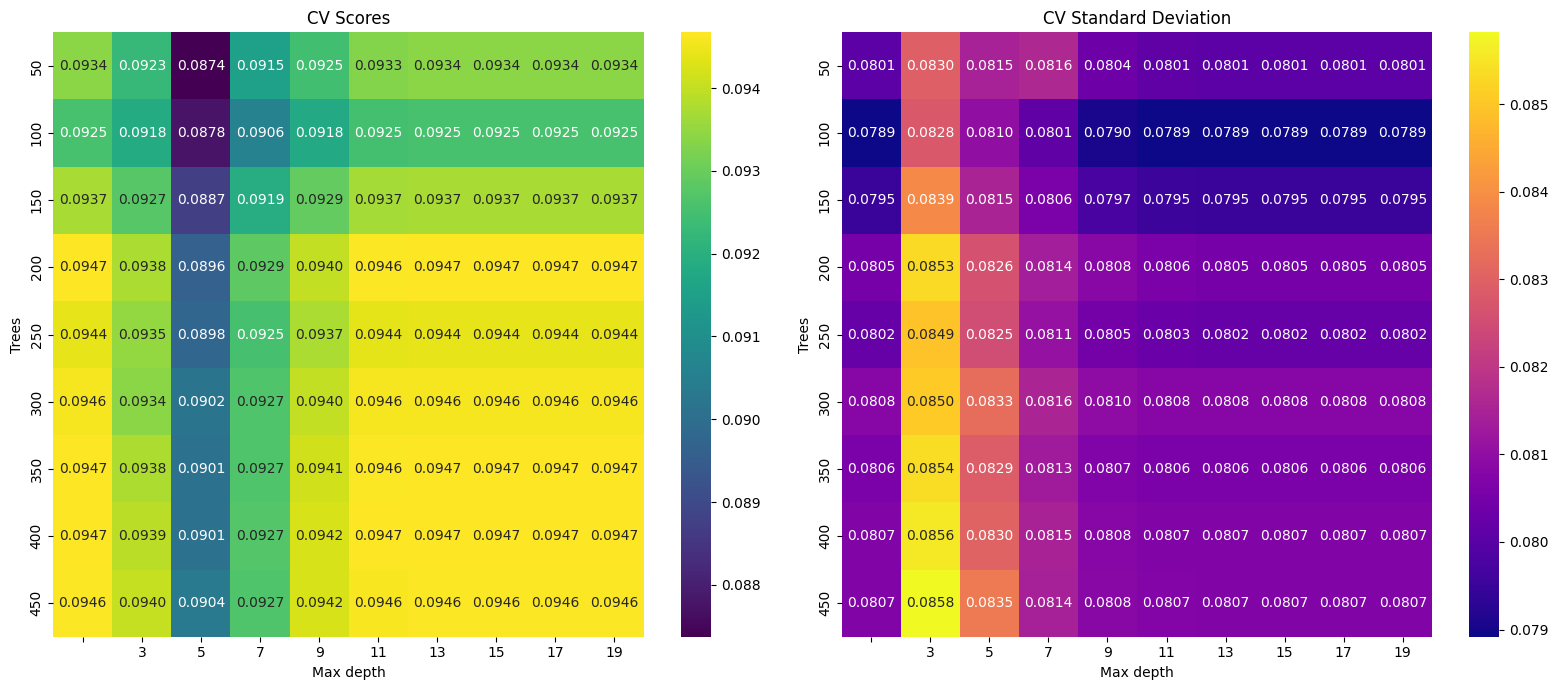

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Heatmap for CV score values
sns.heatmap(A_heatmap_avg, ax=axes[0], cmap='viridis', annot=True, fmt=".4f", xticklabels=depths, yticklabels=n_trees, cbar=True)
axes[0].set_title("CV Scores")
axes[0].set_xlabel("Max depth")
axes[0].set_ylabel("Trees")

# Heatmap for CV scores standard deviation
sns.heatmap(A_heatmap_std, ax=axes[1], cmap='plasma', annot=True, fmt=".4f", xticklabels=depths, yticklabels=n_trees, cbar=True)
axes[1].set_title("CV Standard Deviation")
axes[1].set_xlabel("Max depth")
axes[1].set_ylabel("Trees")

plt.tight_layout()
plt.show()

In [12]:
# Training of the fine tuned model
kf = KFold(n_splits=8, shuffle=True, random_state=RSEED)
fold_scores = []

for train_reactor_idx, val_reactor_idx in kf.split(unique_reactor_labels):
    print('Train-Valid reactor split:')
    print(train_reactor_idx)
    print(val_reactor_idx)
    print("")
    
    # Randomly choose the reactors for training and validating
    train_reactors = unique_reactor_labels[train_reactor_idx]
    val_reactors   = unique_reactor_labels[val_reactor_idx]

    # Masks for spliting the reactors
    train_mask = np.isin(reactor_labels, train_reactors)
    val_mask   = np.isin(reactor_labels, val_reactors)
    
    # Split reactors into train/validation
    X_train, X_val = X[train_mask], X[val_mask]
    y_train, y_val = y[train_mask], y[val_mask]

    # Define the RF model
    model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=RSEED)

    # Train the model
    model.fit(X_train, y_train)

    # Validate
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    fold_scores.append(mse)

print(f"Mean MSE: {np.mean(fold_scores)}")
print(f"MSE StanDev: {np.std(fold_scores)}")

Train-Valid reactor split:
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[0 1]

Train-Valid reactor split:
[ 0  1  2  3  4  6  7  8  9 10 11 12 13 15]
[ 5 14]

Train-Valid reactor split:
[ 0  1  2  3  4  5  6  7  8  9 10 12 14 15]
[11 13]

Train-Valid reactor split:
[ 0  1  2  3  4  5  6  7 10 11 12 13 14 15]
[8 9]

Train-Valid reactor split:
[ 0  1  3  4  5  6  7  8  9 10 11 12 13 14]
[ 2 15]

Train-Valid reactor split:
[ 0  1  2  3  5  6  8  9 10 11 12 13 14 15]
[4 7]

Train-Valid reactor split:
[ 0  1  2  3  4  5  6  7  8  9 11 13 14 15]
[10 12]

Train-Valid reactor split:
[ 0  1  2  4  5  7  8  9 10 11 12 13 14 15]
[3 6]

Mean MSE: 0.09253717961572515
MSE StanDev: 0.07891749453427854


Overall the results in the grid search a similar. We choose to keep the model trained with 100 trees and a maximum depth of `None`. For these hyperparameters, the cross validation score is:

$$\mathbf{CV}_{score} = 0.0925 \pm 0.0789$$

## Plot Adipic Acid prediction

Using the fine-tuned values of the hyperparameters, select a signle train-validation split and visualize the performanc eof adipic acid over time.

Train: ['Reactor_15' 'Reactor_5' 'Reactor_13' 'Reactor_2' 'Reactor_7'
 'Reactor_14' 'Reactor_16' 'Reactor_8' 'Reactor_10' 'Reactor_9'
 'Reactor_11' 'Reactor_6' 'Reactor_12' 'Reactor_1']
Validate: ['Reactor_4' 'Reactor_3']

Total training time: 0.04196286201477051 seconds


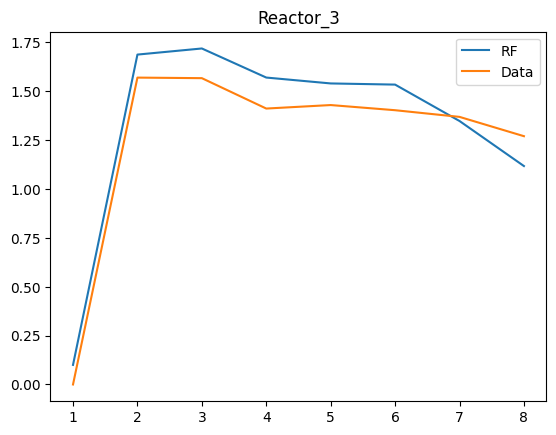

In [32]:
# Choose the reactors for training and validating
train_reactors, val_reactors = train_test_split(unique_reactor_labels, test_size=0.1, random_state=RSEED-1)
print(f'Train: {train_reactors}')
print(f'Validate: {val_reactors}\n')

# Masks for spliting the reactors
train_mask = np.isin(reactor_labels, train_reactors)
val_mask   = np.isin(reactor_labels, val_reactors)

# Split reactors into train/validation
X_train, X_val = X[train_mask], X[val_mask]
y_train, y_val = y[train_mask], y[val_mask]

# Define the RF model
model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=RSEED)

# Train the model
start_time = time.time()
model.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Total training time: {training_time} seconds")

# Predict
y_pred = model.predict(X_val)
i=0
plt.plot(X_val[8:,4], y_pred[0:8,0], label = 'RF')
plt.plot(X_val[8:,4], y_val[0:8,0], label = 'Data')
plt.title(val_reactors[1])
plt.legend();

In [107]:
# Save predicted data in a numpy array
y_pred[0:8,0]
np.save('AdipPred-RF-Reactor_3.npy', y_pred[0:8,0])

# Save ground truth
np.save('AdipPred-GT-Reactor_3.npy', y_val[0:8,0])